# PCA practice with scikit-learn


<details> 

<summary> Summary of Principal Component Analysis </summary>

1. PCA exploits the linear correlation structure among variables to construct new orthogonal principal components, such that the variance of the data is preserved as much as possible in a lower-dimensional space.

2. PCA maximizes variance, rather than class separability or predictive performance.

3. The results of PCA are sensitive to feature scaling and outliers. Feature scaling can be addressed by standardization, while outliers may significantly affect the orientation of the principal axes.

</details>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
import os #module pour connaitre et modifier le répertoire courant où Python cherche les modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import metrics

# permet d'afficher les graphiques dans un notebook
%matplotlib inline

### 0_Background of the database and the relating conceptions

#### 0.1_Dataset Presentation
The data contain, for the year 2021, indicators on countries’ governance (http://info.worldbank.org/governance/wgi/#home) as well as GDP per capita (in current US dollars). The higher the value of an indicator, the better the country performs on that indicator (and vice versa).

In [2]:
f=pd.read_csv("WGI.csv")
print(f.shape)
print(f.columns)

(206, 10)
Index(['Country', 'Continent', 'HDI', 'GDP_percapita', 'CorruptionControl',
       'GovEffectiveness', 'PoliticalStability', 'RegulatoryQuality',
       'RuleLaw', 'VoiceAccountability'],
      dtype='object')


In [ ]:
WGI = pd.read_csv("WGI.csv").dropna()
WGI.shape

(176, 10)

In [4]:
WGI = WGI.set_index("Country")
WGI.shape

(176, 9)

In [5]:
WGI.head()

,Continent,HDI,GDP_percapita,CorruptionControl,GovEffectiveness,PoliticalStability,RegulatoryQuality,RuleLaw,VoiceAccountability
Country,,,,,,,,,
Afghanistan,Asia,0.478,368.0,-1.563735,-1.222106,-2.749167,-1.327919,-1.616430,-1.086220
Albania,Europe,0.796,6492.0,-0.397567,-0.000573,0.257720,0.188962,-0.347468,0.159191
Algeria,Africa,0.745,3690.0,-0.691359,-0.544695,-1.139282,-1.171843,-0.849319,-0.877241
Andorra,Europe,0.858,42137.0,1.230341,1.860201,1.396047,0.871409,1.564011,1.197540
Angola,Africa,0.586,1953.0,-1.411829,-1.039377,-0.386640,-1.001381,-1.080522,-1.167355


#### 0.2_Relating Definations


##### <span style="color:#60a5fa;font-weight:700; font-size:20px;"> 0.2.1_Standardization </span>
$$
z = \frac{x - \mu}{\sigma}
$$
1. Subtracting the mean makes the new variable have a mean of 0; dividing by the standard deviation makes its variance equal to 1.

2. This removes differences in units and scale between variables, since Var(aX) = a² Var(X).



##### <span style="color:#60a5fa;font-weight:700; font-size:20px;"> 0.2.2_Covariance </span>
$$
\mathrm{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$
Variance is a special case: Var(X) = Cov(X, X).

##### <span style="color:#60a5fa;font-weight:700; font-size:20px;"> 0.2.3_Correlation as cosine </span>

After centering the variables, the Pearson correlation coefficient is equal to the cosine of the angle between the two variable vectors.
$$
r_{XY} = \frac{X_c^\top Y_c}{\|X_c\| \, \|Y_c\|} = \cos(\theta),
\quad X_c = X - \bar{x},\; Y_c = Y - \bar{y}.
$$

Pearson correlation coefficient *

##### <span style="color:#60a5fa;font-weight:700; font-size:20px;"> 0.2.4_Total Inertia_总惯性 </span>


In PCA:

1. Total inertia = total variance = the sum of all eigenvalues.

2. The inertia contribution of each principal component = the corresponding eigenvalue / the sum of all eigenvalues.

3. Standardization is applied to each original feature (variable).

4. explained_variance is the variance of each principal component (new axis) after standardization, so it can be greater than 1.

#### <span style="color:#60a5fa;font-weight:700; font-size:20px;"> 0.2.5_Camparison!! </span>

<b><span style="color:#818cf8; font-weight:700; font-size:18px;">1. Viance</span> </b>

<span style="color:#fb7185; font-weight:700; font-size:16px;">1.1  Definition: </span> The degree of dispersion of a random variable around its mean.

<span style="color:#a78bfa; font-weight:700; font-size:16px;">1.2 Interpretation:</span> 

 <span style="font-weight:500; font-size:12px;"> The dispersion of a variable itself.</span> 

<b><span style="color:#818cf8; font-weight:700; font-size:18px;">2. Covariance</span></b>

<span style="color:#fb7185; font-weight:700; font-size:16px;">2.1 Definition: </span> Whether two variables tend to deviate from their respective means at the same time, and whether the directions of deviation are consistent.

<span style="color:#a78bfa; font-weight:700; font-size:16px;">2.2 Interpretation:</span> 

<span style="font-weight:500; font-size:12px;">Variance itself only describes the dispersion of a single variable and does not describe the relationship between x and y; the relationship between variables is characterized by covariance / correlation.
</span>

<b><span style="color:#818cf8; font-weight:700; font-size:18px;">3. Correlation_as_cosine</span></b>

<span style="color:#fb7185; font-weight:700; font-size:16px;">3.1  Definition: </span> Measures the strength and direction of linear correlation between two variables, with values in the range [-1, 1].

<I><span style="color:#60a5fa;font-weight:700; font-size:13px;">PS: Correlation = cosine of the angle between centered variable vectors</span> </I>

<span style="color:#a78bfa; font-weight:700; font-size:16px;">3.2  Interpretation:</span> 

<span style="font-weight:500; font-size:12px;">At the most fundamental geometric level, in the standardized space, each variable is treated as a vector, and θ is the angle between vectors.</span>

<span style="font-weight:500; font-size:12px;">a. The angle is very small, cosθ ≈ 1, positive correlation;</span>

<span style="font-weight:500; font-size:12px;">b. The angle is close to 90°, cosθ ≈ 0, no correlation;</span>

<span style="font-weight:500; font-size:12px;">c. The angle is close to 180°, cosθ ≈ -1, negative correlation.</span>

<b><span style="color:#818cf8; font-weight:700; font-size:18px;">4. Factor Loading</span></b>

<span style="color:#fb7185; font-weight:700; font-size:16px;">4.1 Definition: </span> The weight of an original variable on a given principal component (latent dimension); in standardized PCA, it is equivalent to the correlation coefficient between the variable and that principal component, with values in the range [-1, 1].
<I><span style="color:#60a5fa;font-weight:700; font-size:13px;">PS: Correlation between a variable and a principal component</span></I>

<span style="color:#a78bfa; font-weight:700; font-size:16px;">4.2 Interpretation:</span> 

<span style="font-weight:500; font-size:12px;"> a.  Large loading (positive or negative): the variable is strongly correlated with this principal component.</span>

<span style="font-weight:500; font-size:12px;"> b. oading ≈ 0: this variable hardly contributes to this latent dimension.</span>

<b><span style="color:#818cf8; font-weight:700; font-size:18px;">5. Correlation circle</span></b>:

<span style="color:#fb7185; font-weight:700; font-size:16px;"> 5.1 Definition：</span> A geometric plot that places the loadings of variables on the first two principal components (PC1, PC2) inside the unit circle, used to visualize relationships between variables and between variables and principal components.

<span style="color:#a78bfa; font-weight:700; font-size:16px;">5.2 Interpretation:</span> 

<span style="font-weight:500; font-size:12px;">a. The coordinates of a point = the correlation of the variable with PC1 and PC2.</span>

<span style="font-weight:500; font-size:12px;">b. The angle between points ≈ the correlation between variables.</span>

<span style="font-weight:500; font-size:12px;">c. The closer to the circle → the better the variable is represented on the PC1–PC2 plane.</span>

<span style="font-weight:500; font-size:12px;">d. Close to the center → most information lies in higher dimensions such as PC3, PC4, etc.</span>


### 1_Standardize and Clearn the Raw Datas

In [ ]:
#Réponse
raw_features = WGI.drop(columns=['Continent', 'HDI']) #pour ne garder que les variables quantitatives actives 
#la matrice des variables centrees-reduites, de type data frame
scaled_features = pd.DataFrame(StandardScaler().fit_transform(raw_features), index=raw_features.index, columns=raw_features.columns)
# StandardScaler: apply (x - mean) / standard deviation to each column * refer to the notes on standardization and covariance  
# Here the data are standardized: 
# each variable undergoes a linear transformation so that its mean becomes 0 and its variance becomes 1, thereby removing differences in units and scale.
scaled_features.shape
scaled_features.head()

,GDP_percapita,CorruptionControl,GovEffectiveness,PoliticalStability,RegulatoryQuality,RuleLaw,VoiceAccountability
Country,,,,,,,
Afghanistan,-0.690348,-1.532377,-1.217555,-2.831586,-1.363158,-1.625783,-1.151066
Albania,-0.410757,-0.354030,0.037130,0.330691,0.227071,-0.314383,0.147044
Algeria,-0.538682,-0.650890,-0.521759,-1.138505,-1.199534,-0.833018,-0.933244
Andorra,1.216614,1.290880,1.948404,1.527844,0.942517,1.661022,1.229331
Angola,-0.617985,-1.378884,-1.029867,-0.346969,-1.020830,-1.071953,-1.235634


### 2_Eigenvalue and explained_variance(ratio)

#### 2.1_Fit PCA and Extract Eigenvalues

In [ ]:
pca = PCA() 
# Create a PCA model object 
# (at this stage, it has not yet been fitted to the data; 
# it is just an empty analyzer and does not yet contain results such as principal components or eigenvalues).
trans_pca = pca.fit_transform(scaled_features)
# fit: learn PCA from data X (compute mean, covariance/correlation matrix, eigenvalues, and eigenvectors = principal axes).
# transform(): project the original data onto the principal component space, obtaining the coordinates (scores) of each observation on each component.

In [ ]:

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
# Only the first variable is actually used; 
# the second one is included just for demonstration purposes.

# explained_variance_: the amount of information (eigenvalue) carried by each principal component  
# explained_variance_ratio_: the proportion of total information explained by each principal component

[5.54936831 0.67881604 0.32923786 0.28006852 0.10929055 0.05229301
 0.04092572]
[0.78826254 0.09642273 0.04676674 0.03978246 0.01552423 0.00742798
 0.00581331]


#### 2.2_Table of Eigenvalues and Explained Variance Ratios

In [22]:
eigenvalues = pd.DataFrame(
    {
        "Prin_Com" : ["PC" + str(x + 1) for x in range(7)], 
        "Eigenvalues" : pca.explained_variance_, # eigenvalues  
        "Explained Variance(%)" : np.round(pca.explained_variance_ratio_ * 100, 2),# explained variance percentage   
        "Cumulative Explained Variance(%)" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2) # cumulative explained variance percentage
    }
)
eigenvalues

,Prin_Com,Eigenvalues,Explained Variance(%),Cumulative Explained Variance(%)
0,PC1,5.549368,78.83,78.83
1,PC2,0.678816,9.64,88.47
2,PC3,0.329238,4.68,93.15
3,PC4,0.280069,3.98,97.12
4,PC5,0.109291,1.55,98.68
5,PC6,0.052293,0.74,99.42
6,PC7,0.040926,0.58,100.00


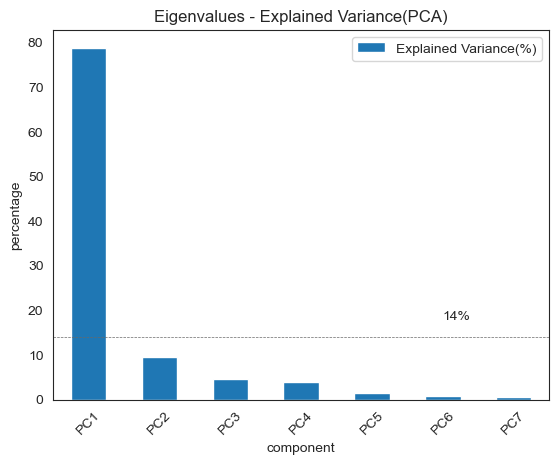

In [ ]:
eigenvalues.plot.bar(
    x="Prin_Com",
    y="Explained Variance(%)",
    title="Eigenvalues - Explained Variance(PCA)"
)
plt.text(5, 18, "14%") # Add text  
# 100% / 7 ≈ 14% (if 7 principal components shared the variance equally, the theoretical average explained variance per component would be 14%)
plt.axhline(y = 14, linewidth = 0.5, color = "dimgray", linestyle = "--") 
plt.xlabel("component")
plt.ylabel("percentage")
plt.xticks(rotation=45)
plt.show()

### 3_Projection onto the First Two Principal Components
<comment>PCA Score Plot (PC1 vs PC2)</comment>

#### 3.1_Score Table for PC1 and PC2

In [ ]:
country_pca_scores = pd.DataFrame({
        'PC1': trans_pca[:,0],# NumPy slicing syntax: [rows, columns]
        'PC2': trans_pca[:,1],
        'Continent': WGI['Continent']},
        index=WGI.index
)
country_pca_scores.head(10)

,PC1,PC2,Continent
Country,,,
Afghanistan,-3.907975,1.208046,Asia
Albania,-0.145976,-0.480424,Europe
Algeria,-2.178754,0.453512,Africa
Andorra,3.713673,-0.170927,Europe
Angola,-2.571966,0.052461,Africa
Antigua and Barbuda,1.426279,-0.796763,North America
Argentina,-0.129124,-0.637234,South America
Armenia,-0.747420,0.383372,Europe
Australia,4.495783,0.678920,Oceania


#### 3.2_Scatter Plot of PCA  ( PC1 vs PC2 )

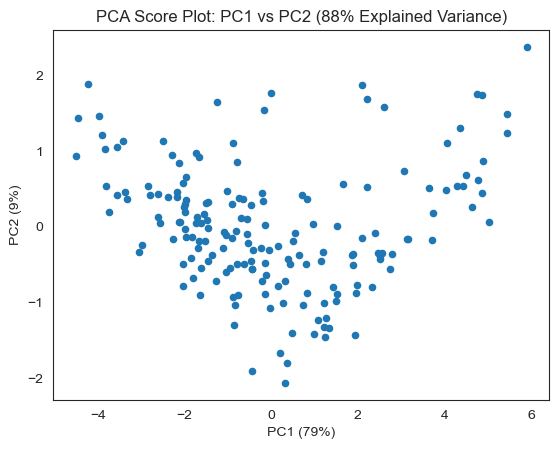

In [ ]:
country_pca_scores.plot.scatter("PC1", "PC2")
plt.xlabel("PC1 (79%)")
plt.ylabel("PC2 (9%)")
plt.title("PCA Score Plot: PC1 vs PC2 (88% Explained Variance)") 
plt.show()


#### 3.3_Annotated PCA Score Plot (Extreme Countries)

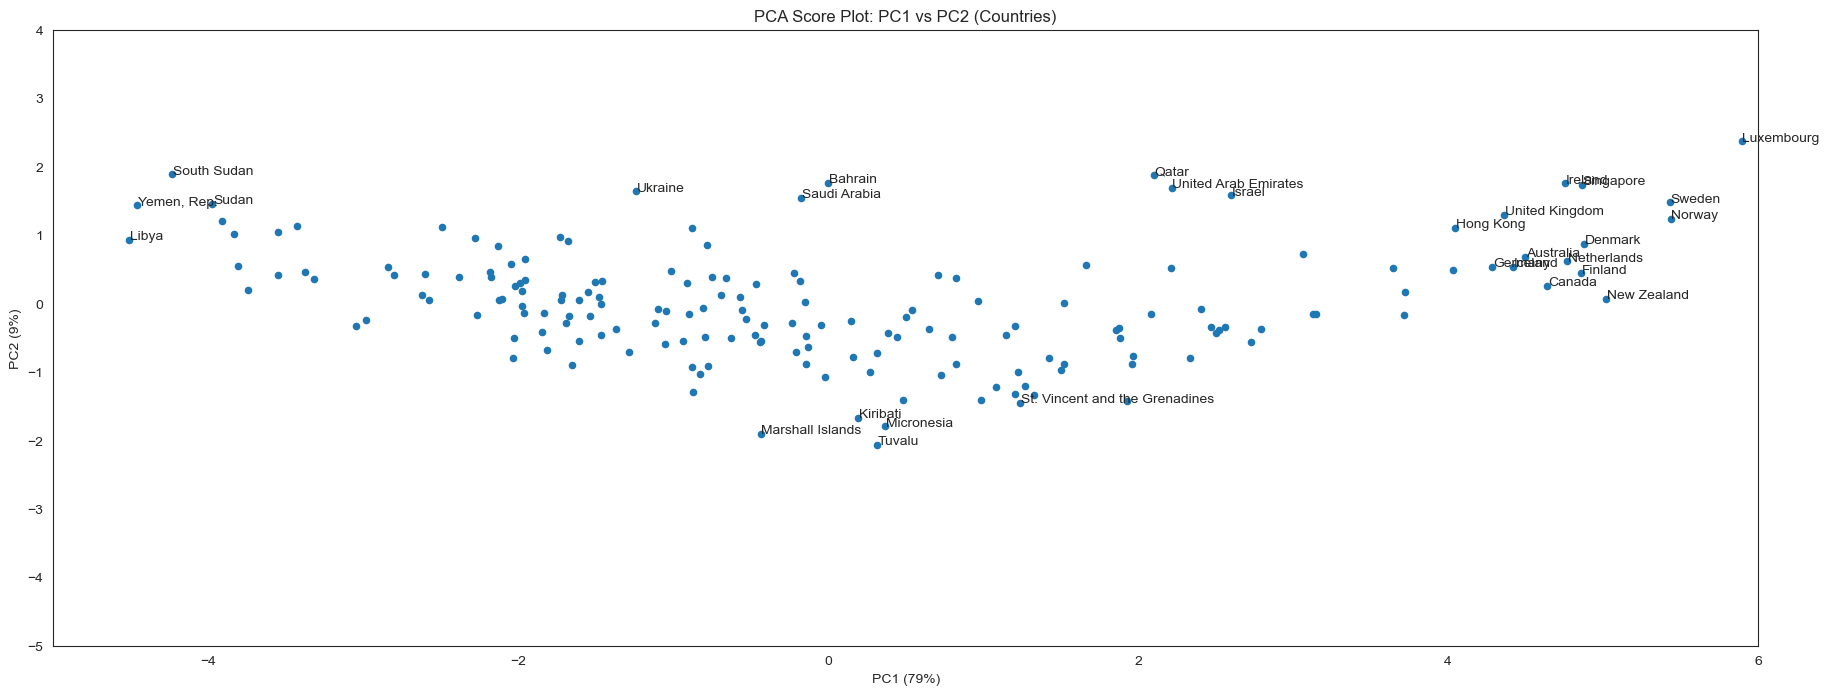

In [ ]:
# Create the figure and axes, and plot the scatter points on the specified axes
fig, ax = plt.subplots(figsize = (22,8)) # plt.subplots(): create a controllable figure and axes, useful when many plot elements need to be adjusted manually
country_pca_scores.plot.scatter("PC1", "PC2", ax = ax) # ax=ax: plot on the same axes (the same figure)

# Take extreme values from PC1 and PC2 using quartiles
x_thr = country_pca_scores['PC1'].abs().quantile(0.9)
y_thr = country_pca_scores['PC2'].abs().quantile(0.9)
# Label the extreme values with country names
for country in country_pca_scores.index:
    if (abs(country_pca_scores.loc[country,'PC1']) > x_thr) | (abs(country_pca_scores.loc[country,'PC2']) > y_thr):
        plt.text(
            country_pca_scores.loc[country,'PC1']+0.005, 
            country_pca_scores.loc[country,'PC2']+0.005, 
            country, 
            horizontalalignment='left',
            rotation_mode='anchor'
        )
        
ax.axis([-5,6,-5,4])
plt.xlabel("PC1 (79%)") 
plt.ylabel("PC2 (9%)")
plt.title("PCA Score Plot: PC1 vs PC2 (Countries)")
plt.show()

#### 3.4_Colored PCA Score Plot by Continent

##### 3.4.1_Set Up Color Palette for PCA Visualization

In [ ]:
# Use a predefined color scheme from matplotlib called "Dark2"  
# "Dark2" comes from ColorBrewer (a color palette designed for categorical data)
palette = plt.get_cmap("Dark2")
# Assign a color to each continent (see below)
colors_by_continent = dict(zip( # Pair each continent name with a color and store them in a dictionary
        country_pca_scores["Continent"].drop_duplicates(), # Extract all unique continent names
        palette(range(6)))# Generate 6 colors
)
colors_by_continent# In matplotlib, colors are RGBA (four channels), where the last one is alpha (transparency)

{'Asia': array([0.10588235, 0.61960784, 0.46666667, 1.        ]),
 'Europe': array([0.85098039, 0.37254902, 0.00784314, 1.        ]),
 'Africa': array([0.45882353, 0.43921569, 0.70196078, 1.        ]),
 'North America': array([0.90588235, 0.16078431, 0.54117647, 1.        ]),
 'South America': array([0.4       , 0.65098039, 0.11764706, 1.        ]),
 'Oceania': array([0.90196078, 0.67058824, 0.00784314, 1.        ])}

##### 3.4.2_Version 1: Manual Legend

In [15]:
legend_index = dict(zip(colors_by_continent.keys(), range(len(colors_by_continent))))
legend_index

{'Asia': 0,
 'Europe': 1,
 'Africa': 2,
 'North America': 3,
 'South America': 4,
 'Oceania': 5}

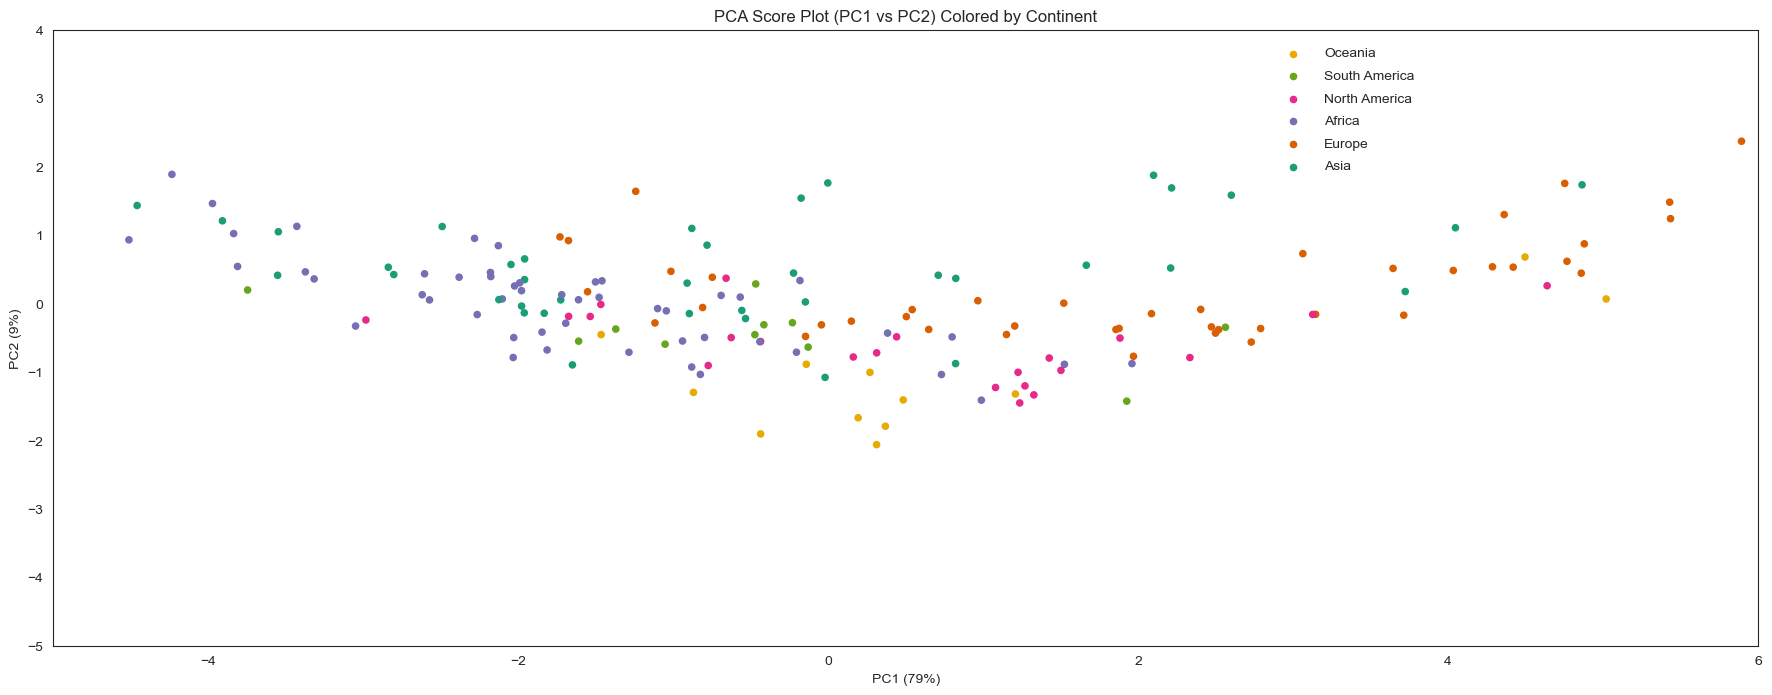

In [ ]:
# Color the scatter plot points
country_pca_scores.plot.scatter(
    x = "PC1", 
    y = "PC2", 
    c = [colors_by_continent[p] for p in country_pca_scores["Continent"]],
    figsize=(22,8)
)

# Manually create the legend
legend_x = 3.0 # Fix the legend position along the x-axis
legend_y0 = 2.0 # Starting y-coordinate of the first legend marker
legend_step = 0.33 # Vertical spacing between legend entries

for cont, col in colors_by_continent.items(): # In each iteration, draw one legend entry for a continent
     y = legend_y0 + legend_index[cont] * legend_step # Compute the y-coordinate of the current continent in the legend
     plt.scatter(legend_x, y, c=[col], s=20) # c: use the color corresponding to this continent for the point; s: marker size
     plt.text(legend_x + 0.2, y, cont, va="center") # Write the continent name to the right of the marker: x/y coordinates, label text, centered alignment

plt.axis([-5,6,-5,4])
plt.xlabel("PC1 (79%)") 
plt.ylabel("PC2 (9%)")
plt.title("PCA Score Plot (PC1 vs PC2) Colored by Continent")
plt.show()

##### 3.4.3_Version 2: Auto Legend

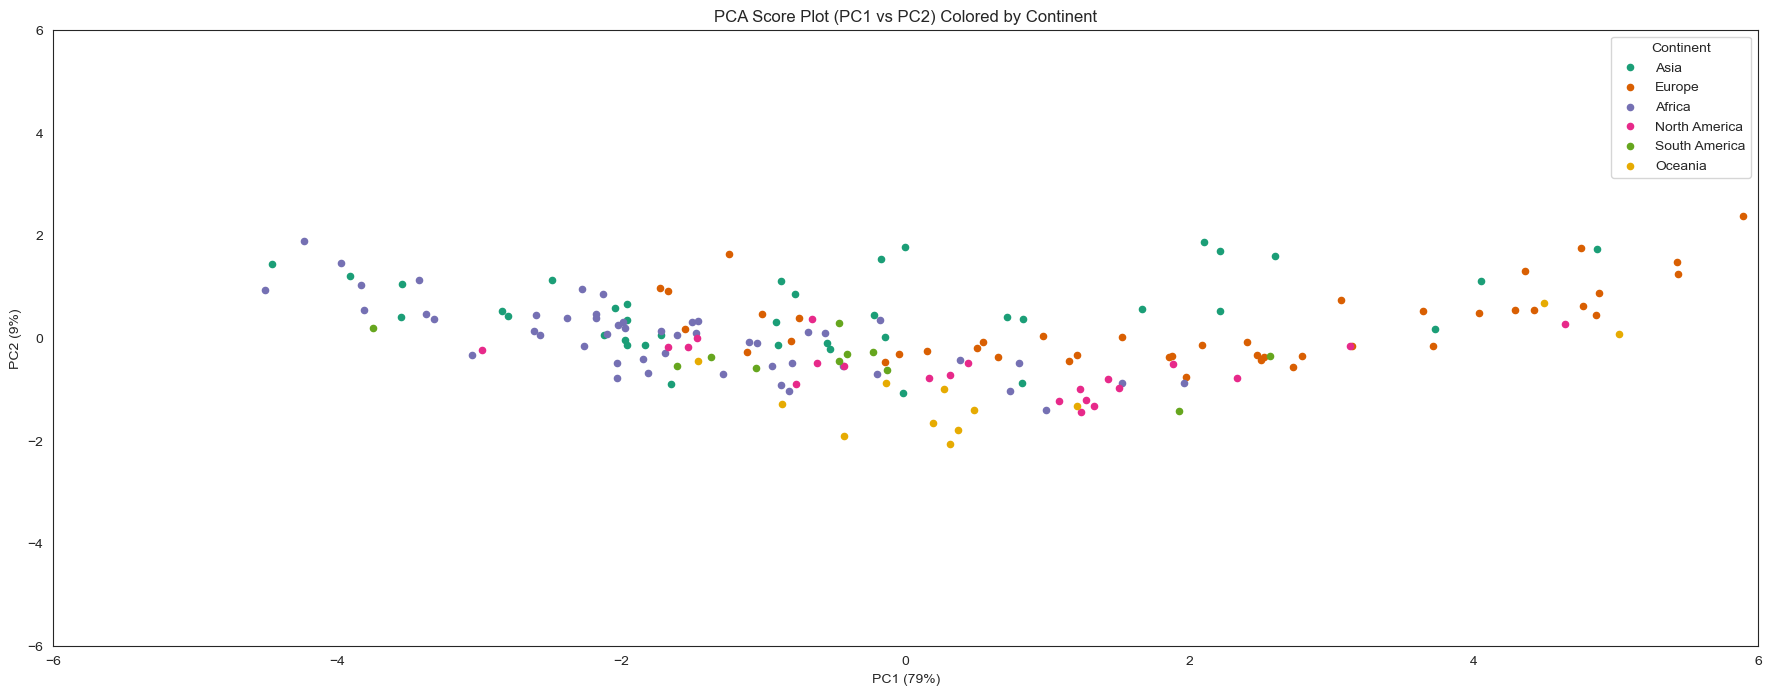

In [ ]:

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(22, 8))

# Plot points grouped by Continent (so the legend can be generated automatically)
for cont, color in colors_by_continent.items():
    sub = country_pca_scores[country_pca_scores["Continent"] == cont] # Filter all countries belonging to the current continent from country_pca_scores
    ax.scatter(sub["PC1"], sub["PC2"], c=[color], label=cont, s=20) # x, y, color, label 

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_xlabel("PC1 (79%)")
ax.set_ylabel("PC2 (9%)")
ax.set_title("PCA Score Plot (PC1 vs PC2) Colored by Continent")

ax.legend(title="Continent", loc="best")
# label=cont: assign a label to the points; ax.legend(): automatically generate the legend
plt.show()

## 4_Variable Loadings on PCs

<Comment>

1.	loading = factor (component) loading → the weight of a variable on a principal component

2.	In standardized PCA, the loading of a variable can be interpreted as the correlation coefficient between the variable and the corresponding principal component;

3.	However, loadings describe the relationship between a variable and a principal component, rather than the correlation between variables;

4.	The latter is represented by correlation.

</Comment>

### 4.1_First Example: variable loadings on PC1 and PC2

In [ ]:
pca_model_2d = PCA(n_components=2)  # Create a PCA object (not yet fitted to the data)
scaled_features_pca = pca_model_2d.fit_transform(scaled_features) # Let this object both fit the model and project the data

eigenvalue = pca_model_2d.explained_variance_         # eigenvalues (variance): the amount of information / variance captured by this principal component

# Loading: how large the component of a variable is along a given principal component axis

# Scale the directions of the principal components by their importance 
# to obtain the actual coordinates (loadings) of each variable in the PCA coordinate system
loadings = pca_model_2d.components_.T * np.sqrt(eigenvalue)   
# pca.components_: the principal component directions computed by PCA, with shape (n_components, n_features)
# .T transpose: convert (n_components, n_features) to (n_features, n_components)

variable_loadings = pd.DataFrame(
    loadings,
    index=scaled_features.columns,
    columns=["PC1_Loading", "PC2_Loading"]
)
variable_loadings


,PC1_Loading,PC2_Loading
GDP_percapita,0.783761,0.499974
CorruptionControl,0.965196,0.019514
GovEffectiveness,0.950451,0.139505
PoliticalStability,0.791354,-0.448941
RegulatoryQuality,0.942588,0.138281
RuleLaw,0.978806,0.025321
VoiceAccountability,0.792056,-0.433231


### 4.2_Second Example: variable loadings on PC1-4

In [ ]:
# Control case: assume there are 4 principal components
pca_model_4d = PCA(n_components=4)
scaled_features_pca = pca_model_4d.fit_transform(scaled_features) 
eigenvalues = pca_model_4d.explained_variance_ 
loadings = pca_model_4d.components_.T * np.sqrt(eigenvalues)
variable_loadings_full = pd.DataFrame(
    loadings,
    index=scaled_features.columns,
    columns=[f"PC{i+1}_Loading" for i in range(loadings.shape[1])]# loadings.shape[1] gives the number of principal components; in this example, it is 4
)
variable_loadings_full

,PC1_Loading,PC2_Loading,PC3_Loading,PC4_Loading
GDP_percapita,0.783761,0.499974,0.012258,0.372606
CorruptionControl,0.965196,0.019514,-0.022684,-0.012063
GovEffectiveness,0.950451,0.139505,-0.054042,-0.216029
PoliticalStability,0.791354,-0.448941,-0.385962,0.152103
RegulatoryQuality,0.942588,0.138281,0.064046,-0.210444
RuleLaw,0.978806,0.025321,-0.020366,-0.101539
VoiceAccountability,0.792056,-0.433231,0.414933,0.129178


### 4.3_Correlation Circle and Summary: Variable Loadings on PC1–PC2

#### 4.3.1_Plot Correlation Circle

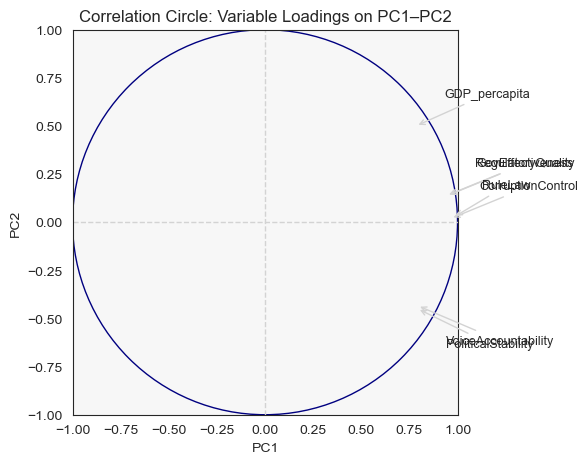

In [ ]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(5, 5))

# Axis limits and title
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title("Correlation Circle: Variable Loadings on PC1–PC2")
ax.patch.set_facecolor("#f7f7f7")

# Reference axes
ax.axvline(0, color="lightgray", linestyle="--", linewidth=1) #axis vertical line
ax.axhline(0, color="lightgray", linestyle="--", linewidth=1) #axis horizontal line

# Plot variable labels (coordinates of variables on PC1–PC2)
for var, row in variable_loadings.iterrows(): # iterrows: iterate over rows (i.e., loop through the DataFrame row by row)
                                             # Each iteration returns a tuple (index, row), where row contains the data of that row (a Series)
    x = row["PC1_Loading"]
    y = row["PC2_Loading"]

    # Compute how much to offset the label in the (x, y) directions, relative to the center of the circle
    dx = 0.15 if x >= 0 else -0.25
    dy = 0.15 if y >= 0 else -0.20

    ax.annotate(    # Add annotations with arrows
        var,        # Set the annotation text to the variable name (var)
        xy=(x, y),  # Target position of the arrow (the true point position on the circle): (x, y)
        xytext=(x + dx, y + dy),# Text placement position
        arrowprops=dict(arrowstyle="->", lw=1, color="lightgrey"),# arrowprops = arrow properties
        fontsize=9
    )

# Unit circle (correlation circle)
circle = Circle((0, 0), 1, fill=False, color="navy") # Circle(xy: center position, radius)
ax.add_patch(circle) # Add this circle object to the current axes (ax)

# Set equal aspect ratio so the circle appears as a circle
ax.set_aspect("equal", adjustable="box") # This ensures the x and y axes use the same scale, preventing the correlation circle from being stretched into an ellipse
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

#### 4.3.2_Summary Table

In [ ]:
summary_table = variable_loadings.copy() # Create a copy of the DataFrame
# Compute cos² (the quality of representation of variables on the PC1–PC2 plane)
summary_table["Cos2_on_PC1_PC2"] = (
    summary_table["PC1_Loading"]**2 + summary_table["PC2_Loading"]**2
)

summary_table = summary_table.sort_values("Cos2_on_PC1_PC2", ascending=False)
summary_table.round(3)

,PC1_Loading,PC2_Loading,Cos2_on_PC1_PC2
RuleLaw,0.979,0.025,0.959
CorruptionControl,0.965,0.020,0.932
GovEffectiveness,0.950,0.140,0.923
RegulatoryQuality,0.943,0.138,0.908
GDP_percapita,0.784,0.500,0.864
PoliticalStability,0.791,-0.449,0.828
VoiceAccountability,0.792,-0.433,0.815


##### <span style="color:#2563eb; font-weight:700; font-size:18px;"> Comments</span>
<span style="color:#fb3235; font-weight:700; font-size:14px;">
Core meaning of cos² in PCA: </span>

The “quality of representation” of a variable on the selected plane (PC1–PC2).

That is, it measures how well a variable is represented on the PC1–PC2 two-dimensional plane.


<span style="color:#fb3235; font-weight:700; font-size:14px;">1. cos² ≈ 1 </span>     This variable is almost completely captured by PC1 and PC2.

<span style="color:#fb3235; font-weight:700; font-size:14px;">2. cos² is small (< 0.3)</span>   This variable is not worth over-interpreting on the PC1–PC2 plane; its main information may lie on other PCs.